# IMPORT

In [19]:
# Model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR 

# Others
import pandas as pd
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import os
import sys
import json

from training.train import train
from preprocessing.preprocessing import *
from dataset.thermal_dataset import thermal_dataset
from utils.csv_utils import *
from models.complete_model import complete_model
from testing.test import test
prefix = '.'
    
pd.set_option('display.max_columns', None)

**Reproducibility and Device Setting**

In [20]:
# Set a seed for reproducibility purposes
seed = 46
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Set the device (cuda for Nvidia GPUs, mps for M1, M2 .. Apple Silicon)
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# Test

In [29]:

# List of result paths to test
'''
result_paths = [
    "/results mandelli/conv_autoencoder/auto-weighted",
    "/results mandelli/conv_autoencoder/median",
    "/results mandelli/conv_autoencoder/average",
    "/results mandelli/conv_autoencoder/minmax_auto-weighted"
]
'''


'''
result_paths = [
    "/results mandelli/lstm_autoencoder/auto-weighted",
    "/results mandelli/lstm_encoder/auto-weighted",
    "/results mandelli/conv_autoencoder/auto-weighted",
]
'''


result_paths = [
    "/results mandelli/lstm_autoencoder/median",
    "/results mandelli/lstm_autoencoder/median_arima",
]


marker = ['o', '^', 's', 'p', 'P']
# Loss function
loss_fn = nn.MSELoss()

# Dictionary to store results for each model
all_results = []

i= 0

# Iterate over each result path
for result_path in result_paths:
    model_path = prefix + result_path + '/model.pt'

    # Read hyperparameters
    with open(prefix + result_path + '/hyperparam.json', 'r') as f:
        hyperparams = json.load(f)

    if hyperparams['norm']:
        X = np.load(prefix + '/data/X' + 'testing' + str(hyperparams['file']) + '.npy')
        Y = np.load(prefix + '/data/Y' + str(hyperparams['window_size']) + 'testing' + str(hyperparams['file']) + '.npy')
    else:
        X = np.load(prefix + '/data/X' + 'testing' + str(hyperparams['file']) + '.npy')
        Y = np.load(prefix + '/data/Y' + str(hyperparams['window_size']) + 'testing' + str(hyperparams['file']) + '.npy')

    print('X', X)
    print('Y', Y)
    datasetTest = thermal_dataset((X, Y), hyperparams['timesteps'], device)
    loaderTest = DataLoader(datasetTest, shuffle=True, batch_size=hyperparams['batch_size'])

    # Section in which we reinitialize the model for testing depending on the hyperparameters.json and ensemble.json (if present) in the directories of results
    # Read Ensemble models data (if complete = True)
    if True:
        with open(prefix + result_path + '/ensemble.json', 'r') as f:
            model_dict = json.load(f)
        with open(prefix + result_path + '/autoencoder.json', 'r') as f:
            autoencoder_dict = json.load(f)
        # Read Ensemble model parameters and initialize the model
        if hyperparams['extractor_type'] == 'conv':
            model = complete_model(model_dict=model_dict,
                                   device=device,
                                   autoencoder_dim=autoencoder_dict['in_kern_out'],
                                   pooling_kernel_size=autoencoder_dict['pooling_kernel_size'],
                                   padding=autoencoder_dict['padding'],
                                   pooling=autoencoder_dict['pooling'],
                                   scale_factor=autoencoder_dict['scale_factor'],
                                   upsample_mode=autoencoder_dict['upsample_mode'],
                                   dropout=autoencoder_dict['dropout'],
                                   mode=hyperparams['mode'],
                                   heterogeneous=hyperparams['heterogeneous'],
                                   timesteps=hyperparams['timesteps'],
                                   norm=hyperparams['norm']
                                   ).to(device)

        elif 'lstm' in hyperparams['extractor_type']:
            model = complete_model(
                model_dict=model_dict,
                device=device,
                timesteps=hyperparams['timesteps'],
                lstm_layers=autoencoder_dict['lstm_layers'],
                autoencoder_dim=autoencoder_dict['in_hidd'],
                dropout=autoencoder_dict['dropout'],
                extractor_type=hyperparams['extractor_type'],
                heterogeneous=hyperparams['heterogeneous'],
                norm=hyperparams['norm'],
                mode=hyperparams['mode']
            ).to(device)

    print(hyperparams)
    # print("state_dict",model.state_dict().keys())

    autoencoder = hyperparams['extractor_type'] == 'conv' or hyperparams['extractor_type'] == 'lstm_autoencoder'
    print(hyperparams['extractor_type'] == 'conv' or hyperparams['extractor_type'] == 'lstm_autoencoder')

    test_model_metrics, test_autoencoder_metrics, loss_model_avg, loss_autoencoder_avg, total_inference_time, inference_time_avg, y_true_list, y_pred_list, x_true_list, x_pred_list = test(
        model=model,
        model_path=model_path,
        test_dataloader=loaderTest,
        loss_fn=loss_fn,
        complete=True,
        autoencoder=autoencoder,
        autoencoder_only=True,
        device=device
    )
    
    path = prefix + result_path  # type ./results/ensemble_batch_256
    
    with open (path + '/train_model_metrics.json', 'r') as f:
        train_metrics = json.load(f)
    with open (path + '/valid_model_metrics.json', 'r') as f:
        valid_metrics = json.load(f)
    i += 1
    # Store results for the current model
    model_results = {
        'result_path': result_path,
        'test_model_metrics': test_model_metrics,
        'test_autoencoder_metrics': test_autoencoder_metrics,
        'loss_model_avg': loss_model_avg,
        'loss_autoencoder_avg': loss_autoencoder_avg,
        'total_inference_time': total_inference_time,
        'inference_time_avg': inference_time_avg,
        'y_true_list': y_true_list,
        'y_pred_list': y_pred_list,
        'x_true_list': x_true_list,
        'x_pred_list': x_pred_list,
        'train_metrics': train_metrics,
        'valid_metrics': valid_metrics,
        'hyperparams': hyperparams,
        'autoencoder': autoencoder,
        'marker':marker[i]
        
    }
    all_results.append(model_results)

    # train_val = True
    '''
    print('Legend metrics:[X1,Y1,Z1]')
    print("Test Model metrics:")
    print(f"rmse: {test_model_metrics['rmse'][0]} , mae: {test_model_metrics['mae'][0]}, r2: {test_model_metrics['r2'][0]}")
    print("Reference metrics(wrt. 0):")
    print(f"rmse: {test_model_metrics['rmse_ref'][0]} , mae: {test_model_metrics['mae_ref'][0]}, r2: {test_model_metrics['r2_ref'][0]}")
    if autoencoder:
        print("Test Autoencoder metrics:")
        print(f"rmse: {test_autoencoder_metrics['rmse'][0]} , mae: {test_autoencoder_metrics['mae'][0]}, r2: {test_autoencoder_metrics['r2'][0]}")
    print("Others:")
    print(f"Model Average Loss: {loss_model_avg}, Autoencoder Average Loss: {loss_autoencoder_avg}, Total Inference Time (All Dataset): {total_inference_time}, Average Inference Time: {inference_time_avg}")
    if hyperparams['ensemble'] == True:
        if not 'NoOpModule' in str(type(model.ensemble)):
            print(f"Weights of the Ensemble models: {model.ensemble.weights.cpu().tolist()}")
        if hyperparams['mode'] == 'auto-weighted':
            with open(model_path[:-8] + '/weights.json', 'w') as file:
                json.dump(model.ensemble.weights.cpu().tolist(), file)
'''

X [[2103. 2134. 2145. 2159.]
 [2103. 2129. 2146. 2158.]
 [2103. 2130. 2147. 2157.]
 ...
 [2099. 2138. 2131. 2135.]
 [2099. 2138. 2132. 2137.]
 [2098. 2139. 2132. 2135.]]
Y [[-0.00051967  0.00128181  0.00348477]
 [-0.0007013   0.00049013  0.00329359]
 [-0.00111148 -0.00047101  0.0035543 ]
 ...
 [ 0.000909   -0.0006761  -0.00069522]
 [ 0.00125834 -0.00072737 -0.00032154]
 [ 0.00130614 -0.00058746 -0.00045189]]
Autoencoder type: LSTM
Autoencoder Summary: lstm_autoencoder(
  (encoder): lstm_encoder(
    (lstm_layers): ModuleList(
      (0): lstm(
        (lstm): LSTM(4, 2, num_layers=2, batch_first=True, dropout=0.14)
      )
    )
  )
  (decoder): lstm_decoder(
    (lstm_layers): ModuleList(
      (0): lstm(
        (lstm): LSTM(2, 4, num_layers=2, batch_first=True, dropout=0.14)
      )
    )
    (linear_decoder): Linear(in_features=800, out_features=800, bias=True)
  )
)
Ensemble Model Summary: ModuleList(
  (0): mlp(
    (linear_layers): ModuleList(
      (0): Linear(in_features=403, o

/Users/cyber_m/Desktop/EAI-1/eai-project/models/complete_model.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.device(

X [[2103. 2134. 2145. 2159.]
 [2103. 2129. 2146. 2158.]
 [2103. 2130. 2147. 2157.]
 ...
 [2099. 2138. 2131. 2135.]
 [2099. 2138. 2132. 2137.]
 [2098. 2139. 2132. 2135.]]
Y [[-0.00051967  0.00128181  0.00348477]
 [-0.0007013   0.00049013  0.00329359]
 [-0.00111148 -0.00047101  0.0035543 ]
 ...
 [ 0.000909   -0.0006761  -0.00069522]
 [ 0.00125834 -0.00072737 -0.00032154]
 [ 0.00130614 -0.00058746 -0.00045189]]
Autoencoder type: LSTM
Autoencoder Summary: lstm_autoencoder(
  (encoder): lstm_encoder(
    (lstm_layers): ModuleList(
      (0): lstm(
        (lstm): LSTM(4, 2, num_layers=2, batch_first=True, dropout=0.15)
      )
    )
  )
  (decoder): lstm_decoder(
    (lstm_layers): ModuleList(
      (0): lstm(
        (lstm): LSTM(2, 4, num_layers=2, batch_first=True, dropout=0.15)
      )
    )
    (linear_decoder): Linear(in_features=800, out_features=800, bias=True)
  )
)
Ensemble Model Summary: ModuleList(
  (0): mlp(
    (linear_layers): ModuleList(
      (0): Linear(in_features=403, o

/Users/cyber_m/Desktop/EAI-1/eai-project/models/complete_model.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=torch.device(

In [ ]:
# Initialize a list of epochs [1,2,3, ...] for the plots x-axis
epochs = list(range(1, 9))

# Compute training loss as the square of rmse for each element because loss = mse
# Both for training and validation
#training_mae = train_metrics['loss']
#valid_mae = valid_metrics['loss'][1:40]


# Create figure and plot signals
plt.figure(figsize=(10, 6))

train_metrics_aw = all_results[0]['train_metrics'] 
valid_metrics_aw = all_results[0]['valid_metrics']
training_loss_aw = train_metrics_aw['loss'][1:9]
valid_loss_aw = valid_metrics_aw['loss'][1:9]

train_metrics_median = all_results[1]['train_metrics'] 
valid_metrics_median = all_results[1]['valid_metrics']
training_loss_median = train_metrics_median['loss'][1:9]
valid_loss_median = valid_metrics_median['loss'][1:9]

train_metrics_avg = all_results[2]['train_metrics'] 
valid_metrics_avg = all_results[2]['valid_metrics']
training_loss_avg = train_metrics_avg['loss'][1:9]
valid_loss_avg = valid_metrics_avg['loss'][1:9]

train_metrics_minmax = all_results[3]['train_metrics']
valid_metrics_minmax = all_results[3]['valid_metrics']
training_loss_minmax = train_metrics_minmax['loss'][1:9]
valid_loss_minmax = valid_metrics_minmax['loss'][1:9]

# Plot with different styles
plt.plot(epochs,training_loss_aw, marker='o', linestyle='-', color='b', label='Training AW STD')   # Blue circles
plt.plot(epochs, valid_loss_aw , marker='o', linestyle='-', color='r', label='Validation AW STD')  # Red squares

plt.plot(epochs,training_loss_median, marker='x', linestyle='-', color='b', label='Training Median')   # Blue circles
plt.plot(epochs, valid_loss_median , marker='x', linestyle='-', color='r', label='Validation Median')  # Red squares

plt.plot(epochs,training_loss_avg, marker='^', linestyle='-', color='b', label='Training Average')   # Blue circles
plt.plot(epochs, valid_loss_avg , marker='^', linestyle='-', color='r', label='Validation Average')  # Red squares

plt.plot(epochs,training_loss_minmax, marker='^', linestyle='-', color='b', label='Training AW MinMax')   # Blue circles
plt.plot(epochs, valid_loss_minmax , marker='^', linestyle='-', color='r', label='Validation AW MinMax')  # Red squares

# Customize the plot
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Conv Autoencoder")
plt.legend()
plt.grid(False)

# Show the plot
plt.show()



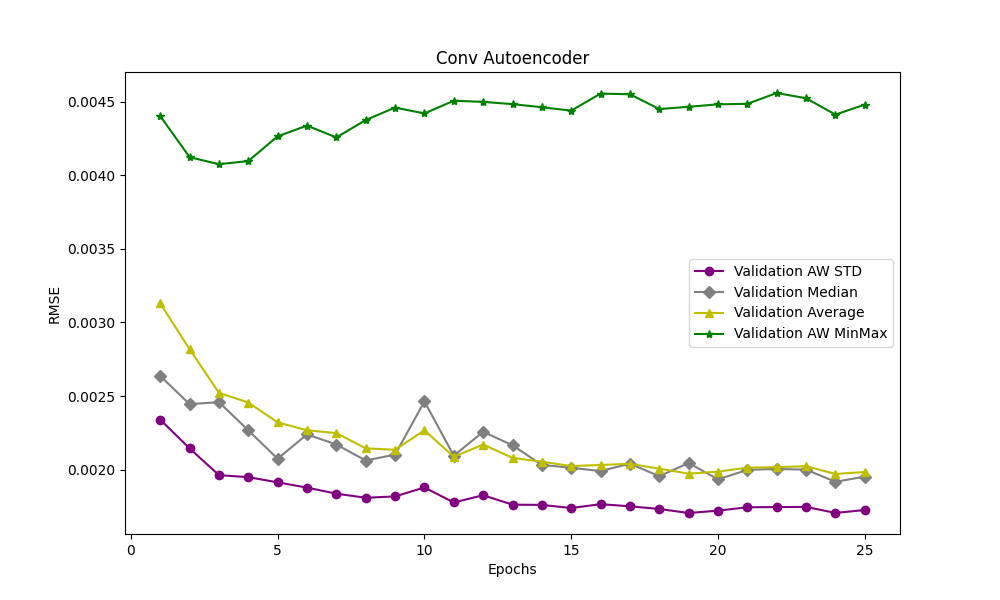

In [18]:
# Initialize a list of epochs [1,2,3, ...] for the plots x-axis
epochs = list(range(1, 26))

# Create figure and plot signals
plt.figure(figsize=(10, 6))

train_metrics_aw = all_results[0]['train_metrics']
valid_metrics_aw = all_results[0]['valid_metrics']
training_rmse_aw = train_metrics_aw['rmse'][1:26]
valid_rmse_aw = valid_metrics_aw['rmse'][1:26]
training_rmse_aw = [rmse[1] for rmse in training_rmse_aw]
valid_rmse_aw = [rmse[1] for rmse in valid_rmse_aw]

train_metrics_median = all_results[1]['train_metrics']
valid_metrics_median = all_results[1]['valid_metrics']
training_rmse_median = train_metrics_median['rmse'][1:26]
valid_rmse_median = valid_metrics_median['rmse'][1:26]
training_rmse_median = [rmse[1] for rmse in training_rmse_median]
valid_rmse_median = [rmse[1] for rmse in valid_rmse_median]

train_metrics_avg = all_results[2]['train_metrics']
valid_metrics_avg = all_results[2]['valid_metrics']
training_rmse_avg = train_metrics_avg['rmse'][1:26]
valid_rmse_avg = valid_metrics_avg['rmse'][1:26]
training_rmse_avg = [rmse[1] for rmse in training_rmse_avg]
valid_rmse_avg = [rmse[1] for rmse in valid_rmse_avg]

train_metrics_minmax = all_results[3]['train_metrics']
valid_metrics_minmax = all_results[3]['valid_metrics']
training_rmse_minmax = train_metrics_minmax['rmse'][1:26]
valid_rmse_minmax = valid_metrics_minmax['rmse'][1:26]
training_rmse_minmax = [rmse[1] for rmse in training_rmse_minmax]
valid_rmse_minmax = [rmse[1] for rmse in valid_rmse_minmax]

# Plot with different styles
#plt.plot(epochs,training_mae_aw, marker='o', linestyle='-', color='b', label='Training LSTM Encoder AW STD')   # Blue circles
plt.plot(epochs, valid_rmse_aw , marker='o', linestyle='-', color='purple', label='Validation AW STD')  # Red squares

#plt.plot(epochs,training_mae_median, marker='x', linestyle='-', color='b', label='Training LSTM Encoder Median')   # Blue circles
plt.plot(epochs, valid_rmse_median , marker='D', linestyle='-', color='gray', label='Validation Median')  # Red squares

#plt.plot(epochs,training_mae_avg, marker='^', linestyle='-', color='b', label='Training LSTM Encoder Average')   # Blue circles
plt.plot(epochs, valid_rmse_avg , marker='^', linestyle='-', color='y', label='Validation Average')  # Red squares

#plt.plot(epochs,training_mae_minmax, marker='^', linestyle='-', color='b', label='Training LSTM Encoder AW Minmax')   # Blue circles
plt.plot(epochs, valid_rmse_minmax , marker='*', linestyle='-', color='green', label='Validation AW MinMax')  # Red squares

#colors = ["blue", "red", "green", "orange", "purple", "magenta", "cyan", "yellow", "black", "gray"]

# Customize the plot
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Conv Autoencoder")
plt.legend()
plt.grid(False)

# Show the plot
plt.show()

In [ ]:
# Initialize a list of epochs [1,2,3, ...] for the plots x-axis
epochs = list(range(1, 26))

# Create figure and plot signals
plt.figure(figsize=(10, 6))

train_metrics_aw = all_results[0]['train_metrics']
valid_metrics_aw = all_results[0]['valid_metrics']
training_mae_aw = train_metrics_aw['mae'][1:26]
valid_mae_aw = valid_metrics_aw['mae'][1:26]
training_mae_aw = [mae[1] for mae in training_mae_aw]
valid_mae_aw = [mae[1] for mae in valid_mae_aw]

train_metrics_median = all_results[1]['train_metrics']
valid_metrics_median = all_results[1]['valid_metrics']
training_mae_median = train_metrics_median['mae'][1:26]
valid_mae_median = valid_metrics_median['mae'][1:26]
training_mae_median = [mae[1] for mae in training_mae_median]
valid_mae_median = [mae[1] for mae in valid_mae_median]

train_metrics_avg = all_results[2]['train_metrics']
valid_metrics_avg = all_results[2]['valid_metrics']
training_mae_avg = train_metrics_avg['mae'][1:26]
valid_mae_avg = valid_metrics_avg['mae'][1:26]
training_mae_avg = [mae[1] for mae in training_mae_avg]
valid_mae_avg = [mae[1] for mae in valid_mae_avg]

train_metrics_minmax = all_results[3]['train_metrics']
valid_metrics_minmax = all_results[3]['valid_metrics']
training_mae_minmax = train_metrics_minmax['mae'][1:26]
valid_mae_minmax = valid_metrics_minmax['mae'][1:26]
training_mae_minmax = [mae[1] for mae in training_mae_minmax]
valid_mae_minmax = [mae[1] for mae in valid_mae_minmax]

# Plot with different styles
#plt.plot(epochs,training_mae_aw, marker='o', linestyle='-', color='b', label='Training LSTM Encoder AW STD')   # Blue circles
plt.plot(epochs, valid_mae_aw , marker='o', linestyle='-', color='purple', label='Validation AW STD')  # Red squares

#plt.plot(epochs,training_mae_median, marker='x', linestyle='-', color='b', label='Training LSTM Encoder Median')   # Blue circles
plt.plot(epochs, valid_mae_median , marker='D', linestyle='-', color='gray', label='Validation Median')  # Red squares

#plt.plot(epochs,training_mae_avg, marker='^', linestyle='-', color='b', label='Training LSTM Encoder Average')   # Blue circles
plt.plot(epochs, valid_mae_avg , marker='^', linestyle='-', color='y', label='Validation Average')  # Red squares

#plt.plot(epochs,training_mae_minmax, marker='^', linestyle='-', color='b', label='Training LSTM Encoder AW Minmax')   # Blue circles
plt.plot(epochs, valid_mae_minmax , marker='*', linestyle='-', color='green', label='Validation AW MinMax')  # Red squares

#colors = ["blue", "red", "green", "orange", "purple", "magenta", "cyan", "yellow", "black", "gray"]

# Customize the plot
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Conv Autoencoder")
plt.legend()
plt.grid(False)

# Show the plot
plt.show()

In [ ]:
# Initialize a list of epochs [1,2,3, ...] for the plots x-axis
epochs = list(range(0, 26))

# Create figure and plot signals
plt.figure(figsize=(10, 6))

train_metrics_aw = all_results[0]['train_metrics']
valid_metrics_aw = all_results[0]['valid_metrics']
training_r2_aw = train_metrics_aw['r2'][0:26]
valid_r2_aw = valid_metrics_aw['r2'][0:26]
training_r2_aw = [r2[1] for r2 in training_r2_aw]
valid_r2_aw = [r2[1] for r2 in valid_r2_aw]

train_metrics_median = all_results[1]['train_metrics']
valid_metrics_median = all_results[1]['valid_metrics']
training_r2_median = train_metrics_median['r2'][0:26]
valid_r2_median = valid_metrics_median['r2'][0:26]
training_r2_median = [r2[1] for r2 in training_r2_median]
valid_r2_median = [r2[1] for r2 in valid_r2_median]

train_metrics_avg = all_results[2]['train_metrics']
valid_metrics_avg = all_results[2]['valid_metrics']
training_r2_avg = train_metrics_avg['r2'][0:26]
valid_r2_avg = valid_metrics_avg['r2'][0:26]
training_r2_avg = [r2[1] for r2 in training_r2_avg]
valid_r2_avg = [r2[1] for r2 in valid_r2_avg]

train_metrics_minmax = all_results[3]['train_metrics']
valid_metrics_minmax = all_results[3]['valid_metrics']
training_r2_minmax = train_metrics_minmax['r2'][0:26]
valid_r2_minmax = valid_metrics_minmax['r2'][0:26]
training_r2_minmax = [r2[1] for r2 in training_r2_minmax]
valid_r2_minmax = [r2[1] for r2 in valid_r2_minmax]

# Plot with different styles
#plt.plot(epochs,training_r2_aw, marker='o', linestyle='-', color='b', label='Training LSTM Encoder AW STD')   # Blue circles
plt.plot(epochs, valid_r2_aw , marker='o', linestyle='-', color='purple', label='Validation AW STD')  # Red squares

#plt.plot(epochs,training_r2_median, marker='x', linestyle='-', color='b', label='Training LSTM Encoder Median')   # Blue circles
plt.plot(epochs, valid_r2_median , marker='D', linestyle='-', color='gray', label='Validation Median')  # Red squares

#plt.plot(epochs,training_r2_avg, marker='^', linestyle='-', color='b', label='Training LSTM Encoder Average')   # Blue circles
plt.plot(epochs, valid_r2_avg , marker='^', linestyle='-', color='y', label='Validation Average')  # Red squares

#plt.plot(epochs,training_r2_minmax, marker='^', linestyle='-', color='b', label='Training LSTM Encoder AW Minmax')   # Blue circles
plt.plot(epochs, valid_r2_minmax , marker='*', linestyle='-', color='green', label='Validation AW MinMax')  # Red squares

#colors = ["blue", "red", "green", "orange", "purple", "magenta", "cyan", "yellow", "black", "gray"]

# Customize the plot
plt.xlabel("Epochs")
plt.ylabel("R2")
plt.title("Conv Autoencoder")
plt.legend()
plt.grid(False)

# Show the plot
plt.show()

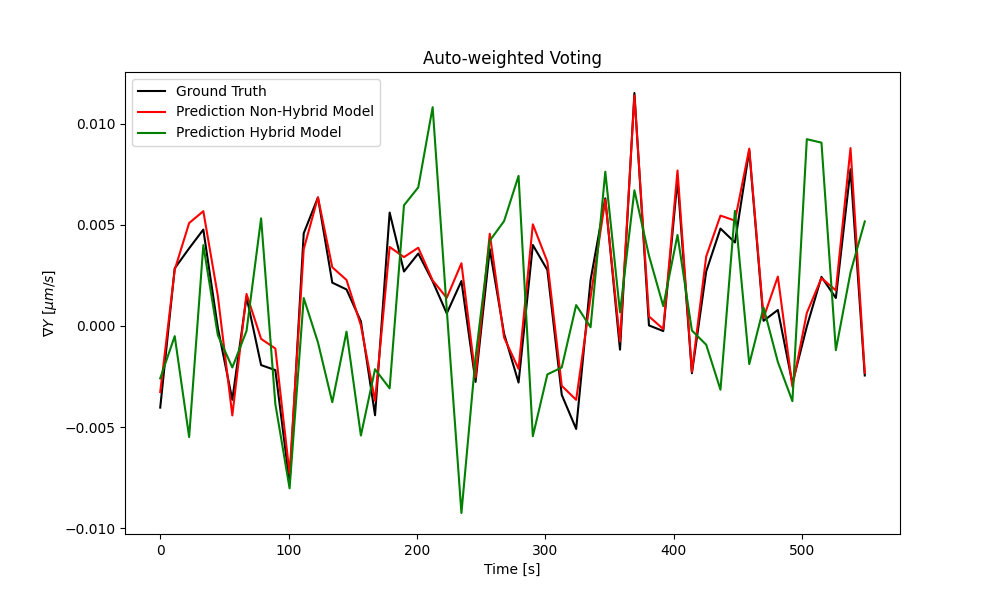

In [32]:
time_since_first = pd.read_csv(f"time_since_first_{all_results[0]['hyperparams']['file']}.csv", header=0, names=['time_since_first'])
time_since_first['time_since_first'] = pd.to_timedelta(time_since_first['time_since_first'])
time_since_first['time_since_first'] = time_since_first['time_since_first'].dt.total_seconds()
time_since_first = time_since_first.squeeze().to_numpy()
t = time_since_first[0:50]

# Create figure and plot signals
plt.figure(figsize=(10, 6))

y_true_list = all_results[0]['y_true_list']
y1_true = [y[1] for y in y_true_list][0:50]

y_pred_list_aw = all_results[0]['y_pred_list']
y1_pred_aw = [y[1] for y in y_pred_list_aw][0:50]

y_pred_list_median = all_results[1]['y_pred_list']
y1_pred_median = [y[1] for y in y_pred_list_median][0:50]

#y_pred_list_avg = all_results[2]['y_pred_list']
#y1_pred_avg = [y[1] for y in y_pred_list_avg][104:110]

#y_pred_list_minmax = all_results[3]['y_pred_list']
#y1_pred_minmax = [y[1] for y in y_pred_list_minmax][104:110]

# Plot with different styles
plt.plot(t, y1_true , marker='', linestyle='-', color='black', label='Ground Truth')  # Red squares
plt.plot(t, y1_pred_aw , marker='', linestyle='-', color='red', label='Prediction Non-Hybrid Model')  # Red squares
plt.plot(t, y1_pred_median , marker='', linestyle='-', color='green', label='Prediction Hybrid Model')  # Red squares
#plt.plot(t,y1_pred_avg, marker='', linestyle='-', color='purple', label='Prediction Conv Autoencoder')   # Blue circles
#plt.plot(t, y1_pred_minmax , marker='', linestyle='-', color='y', label='Prediction AW MinMax')  # Red squares

#colors = ["blue", "red", "green", "orange", "purple", "magenta", "cyan", "yellow", "black", "gray"]

# Customize the plot
plt.xlabel("Time [s]")
plt.ylabel(r'$\nabla Y \ [\mu m / s]$')
plt.title("Median Voting")
plt.legend()
plt.grid(False)

# Show the plot
plt.show()